# Use Regression to define weights for each feature

In [66]:
from os import listdir
import numpy as np
from syntax_features import counts
from feature_extraction_V1 import get_text_features_V1,train_eval_model
import codecs
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [72]:
class TextScorer:    
    lsat_texts = None
    re_features_max = None
    pa_features_max = None
    
    def __init__(self):
        with open('data/LSATtexts.txt', 'r', encoding="utf8") as lsat_file:
            self.lsat_texts = lsat_file.read()
            self.lsat_texts = self.lsat_texts.split("\n\n")
            for text in self.lsat_texts:
                if text[0] == '#':
                    self.lsat_texts.remove(text)
        
        self.re_features_max = np.array(np.mean(counts(self.lsat_texts), axis=0))
        self.pa_features_max = np.array(get_text_features_V1("\n".join(self.lsat_texts)))
        
    
    def score(self, text):
        re_features = np.array(counts([text])).reshape(-1)
        pa_features = np.array(get_text_features_V1(text))
        return re_features,pa_features#re_features / self.re_features_max, pa_features / self.pa_features_max
    
    def get_features(self, text):
        re_features = np.array(counts([text])).reshape(-1)
        pa_features = np.array(get_text_features_V1(text))
        return re_features,pa_features#re_features / self.re_features_max, pa_features / self.pa_features_max

In [73]:
ts = TextScorer()

In [74]:
# counts:
re_feature_names = ["Subordination", "Complements", "Coordination", "Apposition", "Passive verbs", "Parataxis", "Auxiliary Verbs", "Negation", "Prepositional Phrases", "Modifiers"]
# get_text_features_V1
pa_feature_names = ["Mean word length", "Mean sentence length", "Basic english ratio", "Syllables per sentence", "Type token ratio", "#nouns", "#verbs", "#adjectives", "#adverbs", "#pronouns", "#commas"]


## Load Data and define Features

### Training

In [75]:
files = listdir("data/newsela/")
files_with_score = [np.concatenate(
    [[file],file.split(".")[0].split("-")]) for file in files if file[-3:] == "txt"]
files_with_score

[array(['44452-1250.txt', '44452', '1250'],
       dtype='<U14'), array(['44089-660.txt', '44089', '660'],
       dtype='<U13'), array(['44271-1060.txt', '44271', '1060'],
       dtype='<U14'), array(['43993-810.txt', '43993', '810'],
       dtype='<U13'), array(['44384-850.txt', '44384', '850'],
       dtype='<U13'), array(['44107-610.txt', '44107', '610'],
       dtype='<U13'), array(['44256-830.txt', '44256', '830'],
       dtype='<U13'), array(['44256-1050.txt', '44256', '1050'],
       dtype='<U14'), array(['44266-max.txt', '44266', 'max'],
       dtype='<U13'), array(['44395-670.txt', '44395', '670'],
       dtype='<U13'), array(['44581-870.txt', '44581', '870'],
       dtype='<U13'), array(['44322-1090.txt', '44322', '1090'],
       dtype='<U14'), array(['44331-max.txt', '44331', 'max'],
       dtype='<U13'), array(['44428-580.txt', '44428', '580'],
       dtype='<U13'), array(['44442-380.txt', '44442', '380'],
       dtype='<U13'), array(['44271-820.txt', '44271', '820'],
     

In [76]:
lines = []

for path,file_id,newsela_score in files_with_score:
    with codecs.open("data/newsela/"+path, "r",encoding='utf-8', errors='ignore') as f:
        score = np.concatenate(ts.score(f.read()))
        score[12] = 1 / score[12] #basic english
        #score[14] = 0 #ttr
        #print(np.concatenate([[file_id],score]))
        lines += [np.concatenate([[file_id,newsela_score],score])]
        
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["text","newsela_score"],re_feature_names,pa_feature_names]))
df[df.columns[2:]] = df[df.columns[2:]].astype(float)
df.head()

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,44452,1250,0.653846,0.615385,0.423077,0.250000,0.134615,0.019231,1.038462,0.096154,...,22.891304,3.990291,34.043478,0.422602,6.347826,3.543478,1.043478,0.913043,1.239130,1.108696
1,44089,660,0.185185,0.259259,0.314815,0.111111,0.148148,0.000000,0.425926,0.055556,...,12.711538,3.451220,17.038462,0.456884,3.903846,1.846154,0.692308,0.403846,0.673077,0.384615
2,44271,1060,0.290909,0.454545,0.472727,0.054545,0.200000,0.018182,0.836364,0.072727,...,18.760000,3.612245,26.200000,0.413646,4.460000,2.960000,1.760000,0.780000,0.640000,0.780000
3,43993,810,0.375000,0.562500,0.375000,0.031250,0.062500,0.000000,0.937500,0.125000,...,14.385965,3.295238,19.000000,0.460976,3.087719,2.877193,1.385965,0.701754,0.912281,0.631579
4,44384,850,0.333333,0.403509,0.140351,0.017544,0.052632,0.035088,0.438596,0.070175,...,14.333333,3.307692,19.000000,0.426357,4.092593,2.185185,1.055556,0.629630,0.611111,0.574074


### Add ElSAT Text to file

In [77]:
df.loc[df["text"] == "LSAT"]

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
64,LSAT,1500,1.039735,0.64128,1.086093,0.103753,0.302428,0.014349,1.452539,0.186534,...,30.526502,8.518447,45.563015,0.202415,7.180212,4.240283,2.627797,1.385159,1.469965,1.81861


## Plot Result

In [78]:
plot_df = df.loc[df["newsela_score"] != "max"]

In [79]:
#normalize features
norm_df = plot_df.copy()
norm_cols = norm_df.columns[2:]
#newsela_scores = norm_df["newsela_score"]
norm_df[norm_cols] = normalize(plot_df[norm_cols])#(norm_df[norm_cols] - norm_df[norm_cols].mean())/norm_df[norm_cols].std()
#norm_df["newsela_score"] =  
norm_df.head()

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,44452,1250,0.015471,0.014561,0.010010,0.005915,0.003185,0.000455,0.024571,0.002275,...,0.541632,0.094414,0.805504,0.009999,0.150196,0.083842,0.024690,0.021604,0.029319,0.026233
1,44089,660,0.008245,0.011543,0.014016,0.004947,0.006596,0.000000,0.018963,0.002473,...,0.565935,0.153653,0.758576,0.020341,0.173805,0.082193,0.030823,0.017980,0.029966,0.017124
2,44271,1060,0.008726,0.013634,0.014179,0.001636,0.005999,0.000545,0.025086,0.002181,...,0.562699,0.108348,0.785859,0.012407,0.133776,0.088784,0.052791,0.023396,0.019197,0.023396
3,43993,810,0.015041,0.022562,0.015041,0.001253,0.002507,0.000000,0.037603,0.005014,...,0.577012,0.132170,0.762078,0.018489,0.123846,0.115402,0.055590,0.028147,0.036591,0.025332
4,44384,850,0.013358,0.016170,0.005624,0.000703,0.002109,0.001406,0.017576,0.002812,...,0.574390,0.132552,0.761401,0.017086,0.164006,0.087569,0.042300,0.025232,0.024490,0.023005


In [80]:
plot_df["feature_sums"] = plot_df.drop(columns=["text","newsela_score"]).sum(axis=1)
plot_df["feature_sums"] = pd.to_numeric(plot_df["feature_sums"])

/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [81]:
plot_df["newsela_score"] = pd.to_numeric(plot_df["newsela_score"])

/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


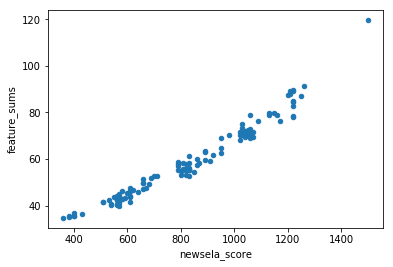

In [82]:
plot_df.plot.scatter(x="newsela_score",y="feature_sums")

In [83]:
plot_df.to_csv("data/newsela/text_features.csv",sep=",",index=False)

## Apply Regression Model

* LogisticRegression
* LassoCV
* RidgeCV

In [12]:
plot_df = pd.read_csv("data/newsela/text_features.csv",sep=",")

In [91]:
def train_eval_model(x_train,y_train,x_test,y_test,model_fn):
    if model_fn == linear_model.LogisticRegressionCV:
        model = model_fn()
    else:
        model = model_fn()
    
    model.fit(x_train,y_train)
    
    print("Evaluation: \n Score: {} \n Feature Importance:".format(model.score(x_train,y_train)))
    for row in zip(*[x_train.columns,model.coef_]):
        print(row)
    
    print("Prediction: ")
    print(model.predict(x_test))
    print("Actual: ")
    print(y_test)
    
    return model

In [92]:
def eval_exclude_cols(df,exclude,x_test,y_test,model_fn):
    col_without = df.columns[2:-1]
    bool_without = [col not in exclude for col in col_without]
    col_without = col_without[bool_without]
    #print(col_without,bool_without)
    x_train = df[col_without]
    y_train = df["newsela_score"]
    
    x_test = [row[bool_without] for row in x_test]
    
    return train_eval_model(
        x_train,y_train,x_test,y_test,model_fn)

In [93]:
#test article
test_articles = []
for file_name,newsela_score in [("43643-1040.txt",1040),("43643-580.txt",580),("43643-800.txt",800)]:
    with codecs.open("data/newsela/test/"+file_name, "r",encoding='utf-8', errors='ignore') as f:
            score = np.concatenate(ts.score(f.read()))
            test_articles += [(score,newsela_score)]
X_test,y_test = list(zip(*test_articles))
X_test,y_test = np.array(X_test),np.array(y_test)

y_test_norm = (y_test - y_test.mean())/y_test.std()

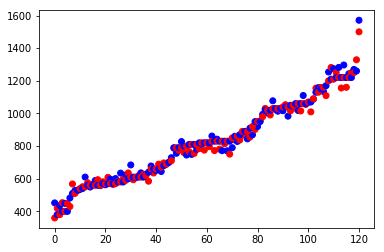

In [94]:
sorted_data = plot_df.sort_values("newsela_score",ascending=True)
X_sorted = sorted_data[plot_df.columns[2:-1]].values
y_sorted = sorted_data["newsela_score"]
model = linear_model.RidgeCV()
model.fit(plot_df[plot_df.columns[2:-1]],plot_df["newsela_score"])
predictions = model.predict(X_sorted)
plt.scatter(x=[range(len(plot_df)),range(len(plot_df))],y=[predictions,y_sorted],c=["blue","red"])

### All Attributes

In [88]:
plot_df.head()

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas,feature_sums
0,44452,1250,0.653846,0.615385,0.423077,0.250000,0.134615,0.019231,1.038462,0.096154,...,3.990291,34.043478,0.422602,6.347826,3.543478,1.043478,0.913043,1.239130,1.108696,87.094135
1,44089,660,0.185185,0.259259,0.314815,0.111111,0.148148,0.000000,0.425926,0.055556,...,3.451220,17.038462,0.456884,3.903846,1.846154,0.692308,0.403846,0.673077,0.384615,49.558307
2,44271,1060,0.290909,0.454545,0.472727,0.054545,0.200000,0.018182,0.836364,0.072727,...,3.612245,26.200000,0.413646,4.460000,2.960000,1.760000,0.780000,0.640000,0.780000,70.693183
3,43993,810,0.375000,0.562500,0.375000,0.031250,0.062500,0.000000,0.937500,0.125000,...,3.295238,19.000000,0.460976,3.087719,2.877193,1.385965,0.701754,0.912281,0.631579,55.665347
4,44384,850,0.333333,0.403509,0.140351,0.017544,0.052632,0.035088,0.438596,0.070175,...,3.307692,19.000000,0.426357,4.092593,2.185185,1.055556,0.629630,0.611111,0.574074,54.558384


In [95]:
#RidgeCV
model = eval_exclude_cols(
    plot_df,
    [],
    X_test,
    y_test,
    linear_model.RidgeCV
)

Evaluation: 
 Score: 0.9755770116304706 
 Feature Importance:
('Subordination', 4.0258415640691156)
('Complements', 22.715017301456157)
('Coordination', -30.826697079151916)
('Apposition', -20.617954268535975)
('Passive verbs', -6.6343846250999796)
('Parataxis', 8.2208858242421137)
('Auxiliary Verbs', 8.8610609359012233)
('Negation', -0.041025314837671745)
('Prepositional Phrases', 15.583448873124741)
('Modifiers', 14.506727867161763)
('Mean word length', 79.171534163507033)
('Mean sentence length', 40.08657156110668)
('Basic english ratio', -11.281159781616305)
('Syllables per sentence', 1.7055987196307218)
('Type token ratio', 23.655241128690896)
('#nouns', 24.758148574023565)
('#verbs', 34.804157506076123)
('#adjectives', -30.448946032872076)
('#adverbs', 10.616902070625459)
('#pronouns', -64.079798914711333)
('#commas', 22.856649869828388)
Prediction: 
[ 1062.00000162   645.53068506   812.66174368]
Actual: 
[1040  580  800]


In [118]:
max_file_scores = model.predict(df.loc[df["newsela_score"] == "max"][df.columns[2:]])
max_text_predictions = (zip(*[df.loc[df["newsela_score"] == "max"]["text"],max_file_scores]))
max_newsela_scores = df.loc[df["newsela_score"] != "max"].groupby("text").max().reset_index()

In [121]:
max_text_predictions = [(ID,pred_score,max_newsela_scores.loc[max_newsela_scores["text"] == ID]["newsela_score"].get_values()[0]) for ID,pred_score in max_text_predictions]
max_text_predictions

[('44266', 1206.462094449641, '820'),
 ('44331', 1424.6621162924621, '810'),
 ('44581', 1279.546969719253, '870'),
 ('44352', 871.45086483767216, '790'),
 ('44118', 1002.6528027783592, '980'),
 ('44482', 1347.1598965693092, '890'),
 ('44452', 1356.9982505887538, '830'),
 ('44442', 938.00052278038572, '800'),
 ('44322', 1703.3851891020586, '910'),
 ('44221', 899.75016158916253, '950'),
 ('44428', 1090.8710482293254, '950'),
 ('44367', 1270.5132329538092, '820'),
 ('43993', 991.51434627611491, '890'),
 ('44453', 1240.4089682665572, '860'),
 ('42157', 1160.2394055925097, '920'),
 ('44271', 1533.3767827776737, '820'),
 ('44107', 1882.942055153449, '830'),
 ('44508', 1340.9143877694069, '830'),
 ('44300', 1295.7302730035281, '800'),
 ('44256', 1295.6759185157239, '830'),
 ('44294', 916.33622938823271, '790'),
 ('44395', 938.96986599678132, '810'),
 ('41496', 1766.4250471248756, '860'),
 ('44418', 1495.5707663420835, '830'),
 ('44357', 1331.0512348979842, '890'),
 ('44089', 1126.458517594258

In [122]:
#Mean Increases between the highest newsela score and the "max" text score
np.mean([int(pred)/int(max_newsela) for ID,pred,max_newsela in max_text_predictions])

1.4636664900915293

In [127]:
#LSAT Text Prediction
model.predict(plot_df[plot_df["text"] == "LSAT"][plot_df.columns[2:-1]])

array([ 1570.93932587])

### Feature Correlation

In [124]:
#LassoCV
eval_exclude_cols(
    plot_df,
    [],
    X_test,
    y_test,
    linear_model.LassoCV
)

Evaluation: 
 Score: 0.9698773971147834 
 Feature Importance:
('Subordination', 0.0)
('Complements', 0.0)
('Coordination', -0.0)
('Apposition', -0.0)
('Passive verbs', -0.0)
('Parataxis', 0.0)
('Auxiliary Verbs', 0.0)
('Negation', -0.0)
('Prepositional Phrases', 0.0)
('Modifiers', 0.0)
('Mean word length', 40.628819381497713)
('Mean sentence length', 26.415907255307804)
('Basic english ratio', -12.628485706548588)
('Syllables per sentence', 14.51611889326173)
('Type token ratio', 0.0)
('#nouns', 21.705948926888858)
('#verbs', 14.396498423033018)
('#adjectives', -0.0)
('#adverbs', 0.0)
('#pronouns', -30.285135474409874)
('#commas', 0.0)
Prediction: 
[ 1060.13267483   640.02132758   810.19566365]
Actual: 
[1040  580  800]


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

### Plot Correlation Matrix

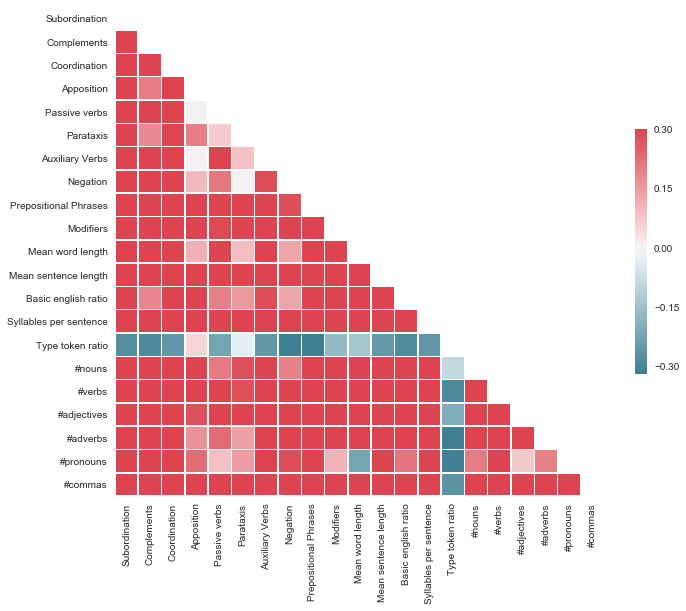

In [126]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = plot_df[plot_df.columns[2:-1]]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Train without verbs

In [90]:
eval_exclude_cols(
    norm_df,
    ["#verbs"],
    X_test,
    y_test_norm,
    linear_model.RidgeCV
)

Evaluation: 
 Score: 0.9740935723338641 
 Feature Importance:
('Subordination', 0.45675800660032395)
('Complements', 0.27433938119115264)
('Coordination', 0.10746800613292516)
('Apposition', 0.022339591742761806)
('Passive verbs', 0.02861895363684509)
('Parataxis', 0.03944033581166784)
('Auxiliary Verbs', 0.24756528299639938)
('Negation', 0.02305439670151703)
('Prepositional Phrases', 1.3637267643543884)
('Modifiers', 0.40744936150409833)
('Mean word length', 1.8740614290425843)
('Mean sentence length', 1.1177652491252716)
('Basic english ratio', 1.0738738509291335)
('Syllables per sentence', 0.9037678127254697)
('Type token ratio', 0.0669882418983973)
('#nouns', 0.7332323237562397)
('#adjectives', -0.0014051100568997197)
('#adverbs', 0.31549616774972883)
('#pronouns', -0.12547550938659413)
('#commas', 0.39822844724889733)
Prediction: 
[2.64809893 1.18528065 1.84931814]
Actual: 
[ 1.24210352 -1.20661485 -0.03548867]


#### Train without Sentence length

In [52]:



eval_exclude_cols( 
    norm_df,
    ["Mean sentence length",'Mean word length'],
    X_test,
    y_test_norm,
    linear_model.RidgeCV
)

Evaluation: 
 Score: 0.9719369333227065 
 Feature Importance:
('Subordination', 0.42467966492472464)
('Complements', 0.3169398634274271)
('Coordination', 0.18615379070150248)
('Apposition', -0.006184607749212779)
('Passive verbs', 0.030749701175378924)
('Parataxis', 0.03220409873294553)
('Auxiliary Verbs', 0.056910830163223916)
('Negation', -0.009932934781098007)
('Prepositional Phrases', 1.4361617409642315)
('Modifiers', 0.5832738156715462)
('Basic english ratio', 1.248497741766897)
('Syllables per sentence', 1.210511529594741)
('Type token ratio', -0.028746670927919445)
('#nouns', 1.0575813688406668)
('#verbs', 0.9180144244300267)
('#adjectives', 0.04752520449980936)
('#adverbs', 0.33638294465894747)
('#pronouns', -0.3356162002410947)
('#commas', 0.3172017455470969)
Prediction: 
[2.96224353 1.45578514 2.13237453]
Actual: 
[ 1.24210352 -1.20661485 -0.03548867]


## Explore Features

In [1]:
from feature_extraction_V1 import eval_exclude_cols

In [219]:
feature_extraction_V1.eval_exclude_cols( 
    plot_df,
    ["Mean sentence length"],
    X_test,
    y_test,
    linear_model.RidgeCV
)

AttributeError: module 'feature_extraction_V1' has no attribute 'eval_exclude_cols'